<a href="https://colab.research.google.com/github/mithinKumar/Machine-Learning-Learners-Space/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [93]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [94]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
from google.colab import drive

# Mount the Google Drive at /content/drive
drive.mount('/content/drive')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
# Setup paths
POS_PATH = "/content/drive/MyDrive/Machine_Learning_ls/final_project/data/positive/*.jpg"
NEG_PATH = "/content/drive/MyDrive/Machine_Learning_ls/final_project/data/negative/*.jpg"
ANC_PATH = "/content/drive/MyDrive/Machine_Learning_ls/final_project/data/anchor/*.jpg"

In [96]:
anchor = tf.data.Dataset.list_files(ANC_PATH).take(3000)
positive = tf.data.Dataset.list_files(POS_PATH).take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH).take(3000)

In [97]:
dir_test = anchor.as_numpy_iterator()

In [98]:
print(dir_test.next())

b'/content/drive/MyDrive/Machine_Learning_ls/final_project/data/anchor/11bd03c1-4f58-11ef-a0c5-00155d1d2527.jpg'


In [99]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [100]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [101]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [102]:
samples = data.as_numpy_iterator()

In [103]:
exampple = samples.next()
exampple

(b'/content/drive/MyDrive/Machine_Learning_ls/final_project/data/anchor/0555a3f0-4f58-11ef-b697-00155d1d2527.jpg',
 b'/content/drive/MyDrive/Machine_Learning_ls/final_project/data/positive/b795d765-4f57-11ef-8793-00155d1d2527.jpg',
 1.0)

In [104]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [105]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [106]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [107]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [108]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [109]:
embedding = make_embedding()

In [110]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 17, 17, 128)       26

In [111]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [112]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [113]:
siamese_model = make_siamese_model()

In [114]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [115]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [116]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [117]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [118]:
test_batch = train_data.as_numpy_iterator()

In [119]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [120]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [121]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()
        loss=None
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [122]:
EPOCHS = 10

In [123]:
train(train_data, EPOCHS)


 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
88/88 [==============================] - 162s 2s/step
0.103815265 0.688826 0.98185486

 Epoch 2/10
88/88 [==============================] - 154s 2s/step
0.13393396 0.91930836 0.992224

 Epoch 3/10
88/88 [==============================] - 155s 2s/step
0.1579768 0.9514563 0.9985444

 Epoch 4/10
88/88 [==============================] - 153s 2s/step
0.084760875 0.9724638 0.99407405

 Epoch 5/10
88/88 [==============================] - 153s 2s/step
0.104703665 0.99142855 0.9956958

 Epoch 6/10
88/88 [==============================] - 153s 2s/step
0.025123399 0.9872521 0.99856734

 Epoch 7/10
88/88 [==============================] - 153s 2s/step
0.07387043 0.9827834 1.0

 Epoch 8/10
88/88 [==============================] - 152s 2s/step
0.03206142 0.99712646 0.99856114

 Epoch 9/10
88/88 [==============================] - 154s 2

In [124]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [125]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [126]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 207ms/step


In [127]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1]

In [128]:
y_true

array([0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [129]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [130]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [131]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 172ms/step
0.98039216 1.0


## 6.4 Viz Results

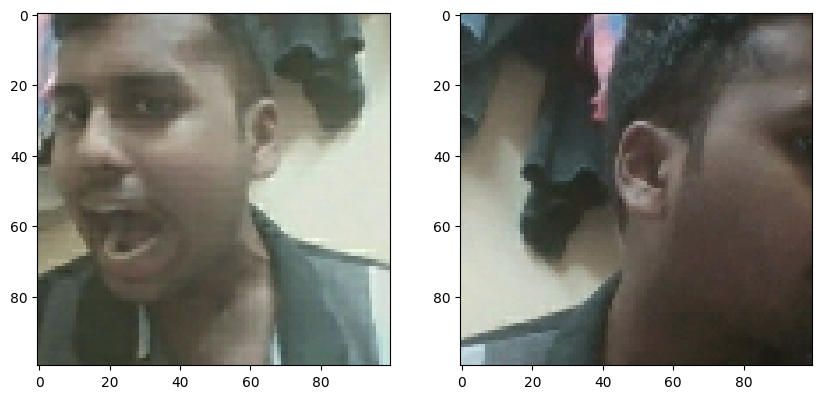

In [132]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [133]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [134]:
# Reload model
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [135]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 258ms/step


array([[9.9085242e-01],
       [9.5961064e-01],
       [9.9387175e-01],
       [4.4275993e-08],
       [8.9961559e-01],
       [9.9963772e-01],
       [2.7181308e-08],
       [3.8221457e-09]], dtype=float32)

In [136]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [137]:
for image in os.listdir("/content/drive/MyDrive/Machine_Learning_ls/final_project/application/verification"):
    validation_img = os.path.join("/content/drive/MyDrive/Machine_Learning_ls/final_project/application/verification", image)
    print(validation_img)

/content/drive/MyDrive/Machine_Learning_ls/final_project/application/verification/729ff0c1-4f56-11ef-ac67-00155d1d2527.jpg
/content/drive/MyDrive/Machine_Learning_ls/final_project/application/verification/97c61e24-4f56-11ef-b59e-00155d1d2527.jpg
/content/drive/MyDrive/Machine_Learning_ls/final_project/application/verification/98a31cca-4f56-11ef-a732-00155d1d2527.jpg
/content/drive/MyDrive/Machine_Learning_ls/final_project/application/verification/725fd822-4f56-11ef-9316-00155d1d2527.jpg
/content/drive/MyDrive/Machine_Learning_ls/final_project/application/verification/687f5368-4f56-11ef-a232-00155d1d2527.jpg
/content/drive/MyDrive/Machine_Learning_ls/final_project/application/verification/688da93a-4f56-11ef-bbe6-00155d1d2527.jpg
/content/drive/MyDrive/Machine_Learning_ls/final_project/application/verification/4c558738-4f56-11ef-8221-00155d1d2527.jpg
/content/drive/MyDrive/Machine_Learning_ls/final_project/application/verification/4c95bb02-4f56-11ef-be0e-00155d1d2527.jpg
/content/drive/M

In [138]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

## 8.2 OpenCV Real Time Verification

In [139]:
cap = cv2.VideoCapture(3)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10

#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [140]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0
